In [252]:
# インポート
import numpy as np
import pandas as pd
import re
import math

# 入力ファイル
dataset1_filename = "testfile1"
dataset2_filename = "testfile2"
aaindex_filename = "aaindex1.txt"

# 読み取り専用で開く
dataset1 = open(dataset1_filename, "r")
dataset2 = open(dataset2_filename, "r")
aaindex = open(aaindex_filename, "r")

In [253]:
# fastaファイルを開いて、sequencesを返す関数
def read_fasta(filename):
    sequences = {}
    current_sequence = None

    with open(filename, "r") as f:
        for line in f:
            line = line.strip()
            if line.startswith(">"):
                current_sequence = line[:]
                sequences[current_sequence] = ""
            else:
                sequences[current_sequence] += line
    return sequences

# fastaファイルを開いて、最も長い配列の長さを返す関数

def longest_sequence(fasta_file):
    sequences = read_fasta(fasta_file)
    longest_length = 0

    for name, sequence in sequences.items():
        if len(sequence) > longest_length:
            longest_length = len(sequence)

    return longest_length

length1 = longest_sequence(dataset1_filename)
length2 = longest_sequence(dataset2_filename)
longest_length = max(length1, length2)

In [256]:
# fastaファイルを二次元配列に格納する。
# longest_lengthに満たない長さの配列は、その長さになるまで"X"を補う。
def fastaToArray(filename, longest_length):
    fasta_array = [[]]
    dataset = open(filename, "r")

    while True:
        reading = dataset.readline()
        reading = reading.rstrip()

        if not reading.startswith(">"):
            if reading == "":
                break
            while len(reading) < longest_length:
                reading += "X"
            fasta_array.append(list(reading))

    fasta_array.remove([])
    return fasta_array

In [257]:
fasta_array_dataset1 = fastaToArray(dataset1_filename, longest_length)
fasta_array_dataset2 = fastaToArray(dataset2_filename, longest_length)

In [258]:
columns = list(range(1, longest_length + 1))
df1 = pd.DataFrame(fasta_array_dataset1, columns=columns)
df2 = pd.DataFrame(fasta_array_dataset2, columns=columns)


,1,2,3,4,5,6,7,8,9,10,...,23,24,25,26,27,28,29,30,31,32
0,M,V,N,L,R,N,A,V,H,S,...,S,D,I,S,V,S,P,V,A,A
1,M,C,P,R,A,A,R,A,P,A,...,A,A,G,A,X,X,X,X,X,X
2,M,V,S,R,M,V,S,T,M,L,...,P,A,F,A,X,X,X,X,X,X
3,M,G,K,N,K,L,L,H,P,S,...,A,X,X,X,X,X,X,X,X,X
4,M,L,P,G,L,A,L,L,L,L,...,X,X,X,X,X,X,X,X,X,X
5,M,G,A,A,S,G,R,R,G,P,...,P,P,Q,P,A,L,A,X,X,X
6,M,R,C,S,P,G,G,V,W,L,...,X,X,X,X,X,X,X,X,X,X
7,M,E,P,W,P,L,L,L,L,F,...,X,X,X,X,X,X,X,X,X,X
8,M,F,R,L,W,L,L,L,A,G,...,X,X,X,X,X,X,X,X,X,X
9,M,L,L,L,G,A,V,L,L,L,...,X,X,X,X,X,X,X,X,X,X


利用したいアミノ酸指標を貼り付ける。

例：
```aaindex_kyte_and_doolittle
I    A/L     R/K     N/M     D/F     C/P     Q/S     E/T     G/W     H/Y     I/V
     1.8    -4.5    -3.5    -3.5     2.5    -3.5    -3.5    -0.4    -3.2     4.5
     3.8    -3.9     1.9     2.8    -1.6    -0.8    -0.7    -0.9    -1.3     4.2
//
```

In [260]:
aa = input("利用したいアミノ酸指標をAAindexからベタ貼り：")

# 正規表現を使用して数字のみを抽出
numeric_values = re.findall(r"-?\d+\.\d+|\d+\.\d+|\d+", aa)

# 文字列から浮動小数点数に変換
numeric_values = [float(value) for value in numeric_values]

# エラーハンドリング
if len(numeric_values) != 20:
    print("アミノ酸指標が20個取得できませんでした")

In [261]:
# AAindexの表記順
index = [
    "A",
    "R",
    "N",
    "D",
    "C",
    "Q",
    "E",
    "G",
    "H",
    "I",
    "L",
    "K",
    "M",
    "F",
    "P",
    "S",
    "T",
    "W",
    "Y",
    "V",
]

In [262]:
# 配列を指標にreplaceするための辞書を作成
replace_dict = {}

for i in range(len(index)):
    replace_dict[index[i]] = numeric_values[i]

In [263]:
df1.replace(replace_dict, inplace=True)
df2.replace(replace_dict, inplace=True)

In [264]:
df1.shape

(10, 32)

In [265]:
# 移動平均幅widthで比較する
# 移動平均を行わない場合は1
width = int(input("移動平均幅width："))

In [266]:
len(df1.columns)

32

In [267]:
# 各セルにアミノ酸指標をもつdfに対して、移動平均幅を持ったcolumnごとの（合計、データ数、平均、分散）を求める関数
def calcSumsCountsAvesVarsOfEachColumn(dataframe, width):

    # 平均とデータ数を計算
    # columnごとに回して実行
    # "X"以外なら（数値なら）sumに追加してcount+1する。
    # sum, countをsums[], counts[]にappend
    # 各columnに対してforループを回す
    sum_values = []
    counts = []
    averages_include_width = []

    for column in dataframe.columns:
        sum_value = 0
        count = 0
        ave = 0

        for index in dataframe.index:
            if dataframe.loc[index, column] != "X":
                sum_value += dataframe.loc[index, column]
                count += 1

        sum_values.append(sum_value)
        counts.append(count)

    # 分散を計算
    variances_include_width = []
    for column in dataframe.columns:
        # 注目している列+移動平均幅分の列 で平均を求める
        sum_include_width = sum(sum_values[column -1:column -1 +width])
        counts_include_width = sum(counts[column -1:column -1 +width])

        if counts_include_width != 0:
            ave = sum_include_width / counts_include_width
        else: # 0の場合はfloat("nan")を代入する
            ave = float("nan")

        averages_include_width.append(ave)

        sum_deff_sqrt = 0

        for index in dataframe.index:
            for w in range(width):
                if column + w > len(df1.columns):
                    # 範囲外を参照する際は分散の計算は行わない
                    sum_deff_sqrt += 0
                elif dataframe.loc[index, column + w] != "X":
                    # 分散v = （平均と各要素の差）^2 の合計 / データ数
                    sum_deff_sqrt += (ave - dataframe.loc[index, column + w]) ** 2

        if counts_include_width != 0:
            var = sum_deff_sqrt / counts_include_width
        else:
            var = float("nan")

        variances_include_width.append(var)

    return sum_values, counts, averages_include_width, variances_include_width

In [268]:
sums_df1, counts_df1, averages_df1, variances_df1 = calcSumsCountsAvesVarsOfEachColumn(
    df1, width
)
sums_df2, counts_df2, averages_df2, variances_df2 = calcSumsCountsAvesVarsOfEachColumn(
    df2, width
)

In [274]:
t_value_array = []
variances_array = []
datanums_1 = []
datanums_2 = []

for i in range(longest_length - width + 1):
    datanum1 = sum(counts_df1[i:i + width])
    datanum2 = sum(counts_df2[i:i + width])
    # t値を求める。0割りが発生する場合はfloat("nan")を代入
    temp1 = (variances_df1[i]) * (datanum1 - 1) + (variances_df2[i]) * (datanum2 - 1)
    if (datanum1 + datanum2 - 2) == 0 or datanum1 == 0 or datanum2 == 0:
        t_value = float("nan")
        variance = float("nan")
    else:
        variance = temp1 / (datanum1 + datanum2 - 2)
        temp2 = np.sqrt(variance) * np.sqrt((1 / datanum1) + (1 / datanum2))
        temp3 = abs(averages_df1[i] - averages_df2[i])
        t_value = temp3 / temp2

    t_value_array.append(t_value)
    variances_array.append(variance)
if width > 1:
    for i in range(width - 1):
        t_value_array.append(float("nan"))
t_value_array

[0.5062143817549491,
 0.10946842823488832,
 0.8854978329853651,
 0.41192459925192365,
 0.691326774649472,
 0.3794322479022348,
 1.3006394704496707,
 0.9479647205057773,
 2.65551174292815,
 1.0293584963662927,
 1.511885715620986,
 0.6286324413490043,
 1.3717310987329383,
 1.424896299337723,
 0.4453067024907483,
 0.3320551022357387,
 1.9482096449183632,
 1.4587846950935346,
 0.8571513986335039,
 0.8517563117977471,
 0.12129040827598545,
 0.3217042865024653,
 1.0422948446367226,
 1.0760486754114629,
 0.5691395803297561,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan]

In [270]:
t_boader_percent = float(input("帰無仮説を棄却するとするp値の閾値"))
# 例：0.95( =有意水準5%)
# 修論では0.01%を利用

In [271]:
from scipy.stats import t

t_boader_array = []
for i in range(longest_length - width + 1):
    datanum1 = sum(counts_df1[i:i + width])
    datanum2 = sum(counts_df2[i:i + width])
    degree_of_freedom = datanum1 + datanum2 - 2

    t_value = t.ppf(q=t_boader_percent, df=degree_of_freedom)
    t_boader_array.append(t_value)

if width > 1:
    for i in range(width - 1):
        t_boader_array.append(float("nan"))

t_boader_array

[1.671552762153672,
 1.671552762153672,
 1.671552762153672,
 1.671552762153672,
 1.671552762153672,
 1.671552762153672,
 1.671552762153672,
 1.671552762153672,
 1.671552762153672,
 1.671552762153672,
 1.671552762153672,
 1.671552762153672,
 1.671552762153672,
 1.671552762153672,
 1.6725223027163505,
 1.6741162362294313,
 1.6765508919142629,
 1.6794273915744247,
 1.685954457643814,
 1.6972608943617378,
 1.7138715277470473,
 1.729132811521367,
 1.74588367627624,
 1.7709333959867988,
 1.8331129326536333,
 1.9431802803927818,
 2.13184678133629,
 2.3533634348018264,
 2.919985580355516,
 6.313751514800932,
 nan,
 nan]

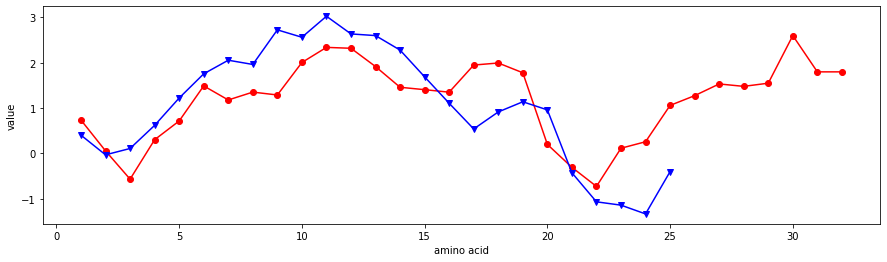

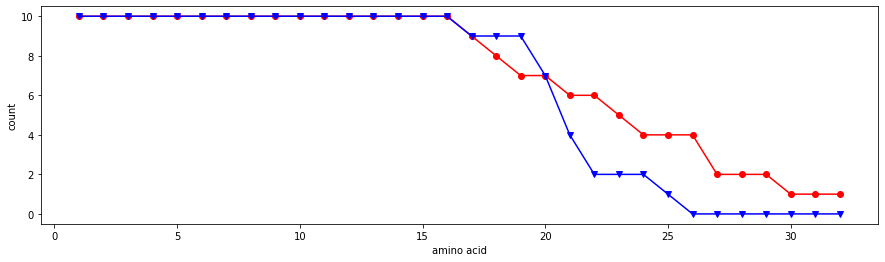

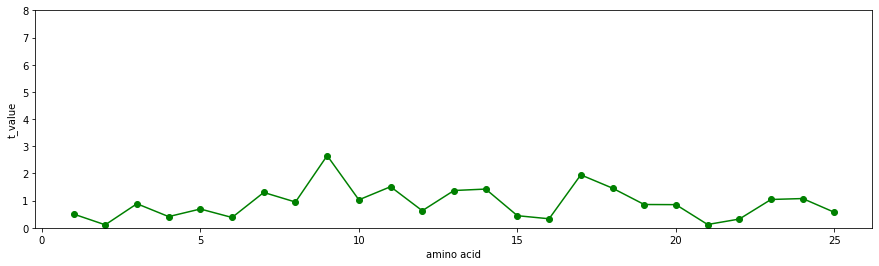

In [272]:
# countのグラフ表示
# テストシナリオ作成

import matplotlib.pyplot as plt

i = 0
frag = 0
significance_array = []

for j in range(longest_length - width + 1):
    if any(math.isnan(x) for x in t_value_array):
        null_frag = 1
    elif t_value_array[j] > t_boader_array[j]:
        significance_array.append(j)
        frag = 1

if True: # if frag == 1
    frag = 0
    plt.figure(figsize=(15, 4))
    plt.plot(columns, averages_df1, color="red", marker="o")
    plt.plot(columns, averages_df2, color="blue", marker="v")
    if len(significance_array) != 0:
        max_y = max(max(averages_df1), max(averages_df2))
        min_y = min(min(averages_df1), min(averages_df2))
        for k, _ in enumerate(significance_array):
            plt.plot(
                [significance_array[k], significance_array[k]],
                [min_y, max_y],
                "green",
                linestyle="dashed",
            )
    plt.xlabel("amino acid")
    plt.ylabel("value")
    plt.show()
    significance_array = []

    plt.figure(figsize=(15, 4))
    plt.xlabel("amino acid")
    plt.ylabel("count")
    plt.plot(columns, counts_df1, color="red", marker="o")
    plt.plot(columns, counts_df2, color="blue", marker="v")
    plt.show()

    plt.figure(figsize=(15, 4))
    plt.ylim(0, 8)
    plt.plot(columns, t_value_array, color="green", marker="o")
    plt.xlabel("amino acid")
    plt.ylabel("t_value")
    plt.show()
